# 10. Validation and tuning

The first step is to activate the packages and load the data.

In [1]:
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn import tree

from plotnine import *
from plotnine.data import *
np.random.seed(0)

In [3]:
#data_ml = pyreadr.read_r(insert path of data_ml.RData)["data_ml"]
data_ml.date = pd.to_datetime(data_ml.date)

data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)

We also copy/paste some chunks from Chapter 2.


In [4]:
stock_ids = data_ml.stock_id.unique() 
stock_days = data_ml.stock_id.value_counts().sort_index() 
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]

returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns_short.pivot_table(index=['date'],columns='stock_id',values='R1M_Usd')  
features = list(data_ml.columns[2:95]) 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]
data_ml['R1M_Usd_C'] = data_ml.R1M_Usd >  data_ml.groupby('date').R1M_Usd.transform('median')
data_ml['R12M_Usd_C'] = data_ml.R12M_Usd >  data_ml.groupby('date').R12M_Usd.transform('median')
separation_date = dt.strptime("2014-01-15","%Y-%m-%d")
training_sample = data_ml[data_ml.date < separation_date]
testing_sample = data_ml[data_ml.date  >= separation_date]

Below, we compute a ROC curve for a given set of predictions on the testing sample. 
The curve is of course computed with respect to a dataset & a predictive model. We use a random forest classifier

In [5]:
fit_RF_C = RandomForestClassifier( max_samples = 20000,  #If bootstrap is True, the number of samples to draw from X to train each base estimator.
                                  bootstrap = False,     #Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.
                                 min_samples_leaf = 250, #The minimum number of samples required to be at a leaf node.            
                                 n_estimators = 40,      #The number of trees in the forest.          
                                 max_features = 30       #The number of features to consider when looking for the best split: 
                                 )

fit_RF_C.fit(training_sample[features], training_sample.R1M_Usd_C)

RandomForestClassifier(bootstrap=False, max_features=30, max_samples=20000,
                       min_samples_leaf=250, n_estimators=40)

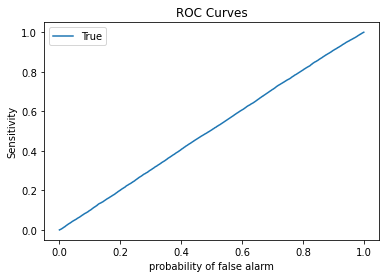

In [6]:
scores = fit_RF_C.predict_proba(testing_sample[features])[:,1]
fpr, tpr, thresholds = roc_curve(testing_sample.R1M_Usd_C, scores)
roc_auc = roc_auc_score(testing_sample.R1M_Usd_C, scores)
plt.plot(fpr, tpr)
plt.title("ROC Curves")
plt.xlabel("probability of false alarm")
plt.ylabel("Sensitivity")
plt.legend([True])

To illustrate the variance-bias tradeoff, we build 2 trees: one small and one deep.


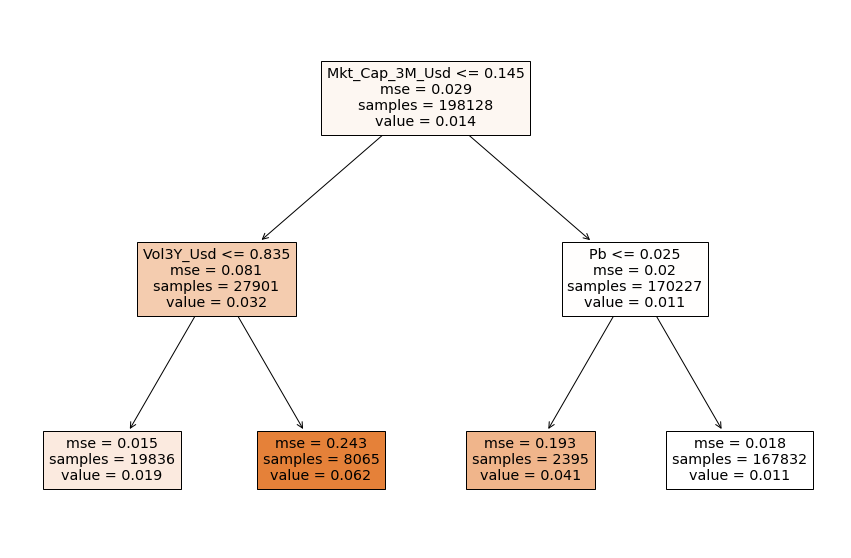

In [7]:
fit_tree_simple = DecisionTreeRegressor(
                                max_depth = 2,               #The maximum depth of the tree
                                #skip  ccp_alpha = 0.0001    #Complexity parameter used for Minimal Cost-Complexity Pruning. smaller cp = more leaves    
                                )
fit_tree_simple.fit(training_sample[features], training_sample.R1M_Usd)
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(fit_tree_simple, 
                   feature_names=features,  
                   class_names=data_ml.R1M_Usd,
                   filled=True)

The model only has 4 clusters, which means that the predictions can only take four values. The model is simple!


In [8]:
print("Bias:", (fit_tree_simple.predict(testing_sample[features]) - testing_sample.R1M_Usd  ).mean() )
print("VAR:",  np.var(fit_tree_simple.predict(testing_sample[features])) )

Bias: 0.0049739165383303205
VAR: 0.0001397982854475226


On average, the error is slightly positive, with an overall overestimation of `r round(mean(predict(fit_tree_simple, testing_sample) - testing_sample$R1M_Usd),4)` . As expected, the variance is very small (`r round(var(predict(fit_tree_simple, testing_sample)),4)`).

For the complex model, we take the boosted tree that was obtained in chapter on trees. The model aggregates 40 trees with a maximum depth of 4, it is thus undoubtedly more complex. The amount of code that generates the model is larger compared to other models notably because of variable pre-processing.

In [9]:
top20 = training_sample.R1M_Usd.quantile(0.8) 
bottom20= training_sample.R1M_Usd.quantile(0.2)
train_features = training_sample[training_sample.R1M_Usd>top20]
train_features = train_features.append(training_sample[training_sample.R1M_Usd<bottom20])
train_features = train_features.sort_values(by=['stock_id','date'])
train_features_xgb = train_features[features_short]
train_label_xgb = train_features.R1M_Usd
mono_const = np.zeros(len(features))
mono_const += (np.array(features)=='Mkt_Cap_12M_Usd' ) * -1
mono_const += (np.array(features)=='Pb' ) * -1
mono_const += (np.array(features)=='Mom_11M_Usd' ) * 1
fit_xgb = xgb.XGBRegressor(     
              learning_rate  = 0.3,                                                        #Boosting learning rate                 
              objective = "reg:linear",                                                    #Specify the learning task and the corresponding learning objective or a custom objective function to be used      
              max_depth = 4,                                                               #Maximum tree depth for base learners.
              reg_lambda = 1,                                                              #L2 regularization term on weights
              gamma = 0.1,                                                                 #Minimum loss reduction required to make a further partition on a leaf node of the tree.
              n_estimators = 30,                                                           #Number of trees in random forest to fit.
              monotone_constraints = '('+','.join(str(int(x)) for x in mono_const) + ')', #Constraint of variable monotonicity. See tutorial for more information.
              verbosity  = 0)                                                              #The degree of verbosity

xgb_test = testing_sample[features_short]
fit_xgb.fit(train_features_xgb,train_label_xgb )
print("Bias:", (fit_xgb.predict(xgb_test) - testing_sample.R1M_Usd  ).mean() )
print("VAR:", np.var(fit_xgb.predict(xgb_test))  ) 

Bias: 0.0032499595079757784
VAR: 0.0022067653


The bias is indeed smaller compared to that of the simple model, but in exchange, the variance increases sustantially. 

Below, we move towards grid search in hyper-parameter optimization.

In [10]:
eta = [0.1, 0.3, 0.5, 0.7, 0.9]         
nrounds = [10, 50, 100]                 
reg_lambda =  [0.01, 0.1, 1, 10, 100]

Given the computational cost of grid search, we perform the exploration on the dataset with the small number of features (which we recycle from the chapter on trees). In order to avoid the burden of loops, we resort to the functional programming capabilities of R, via the *purrr* package. This allows us to define a function that will lighten and simplify the code. This function, coded below, takes data and parameter inputs and returns an error metric for the algorithm. We choose the mean squared error to evaluate the impact of hyperparameter values.


In [11]:
grd_list = []
for i in eta:
    for j in nrounds:
        for k in reg_lambda:
            grd_dict = {}
            grid_par = xgb.XGBRegressor(     
                          learning_rate  = i,          #Boosting learning rate                
                          objective = "reg:linear",    #Specify the learning task and the corresponding learning objective or a custom objective function to be used        
                          max_depth = 5,               #Maximum tree depth for base learners.       
                          reg_lambda = k,              #L2 regularization term on weights           
                          gamma = 0.1,                 #Minimum loss reduction required to make a further partition on a leaf node of the tree.       
                          n_estimators = j,            #Number of trees in random forest to fit.         
                          verbosity  = 0,              #The degree of verbosity
                        )
            grid_par.fit(train_features_xgb,train_label_xgb )
            pred = grid_par.predict(xgb_test)
            grd_dict['eta'] = i
            grd_dict['nrounds'] = j
            grd_dict['reg_lambda'] = k
            grd_dict['error'] = mean_squared_error(pred, testing_sample.R1M_Usd)**2
            grd_list.append(grd_dict)
grd = pd.DataFrame(grd_list)

Once the squared mean errors have been gathered, it is possible to plot them. We chose to work with 3 parameters on purpose because their influence can be simultaneuously plotted on one graph. 


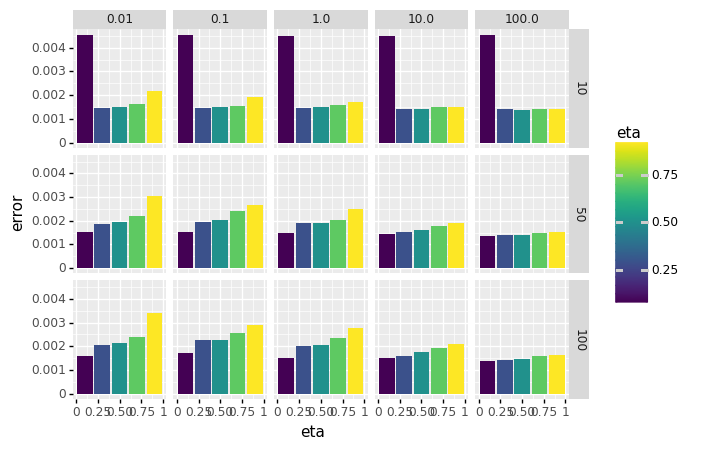

<ggplot: (139623437895)>

In [12]:
(
    ggplot(grd, aes(x='eta', y='error', fill='eta'))
    +geom_bar(stat = "identity") 
    +facet_grid( ("nrounds","reg_lambda")) 
)